# Implementation of a Newton–Raphson solver for nonlinear elasticity

In this notebook, we will analyse the same problem as in the previous notebook [Hyperelasticity_problem.ipynb](Hyperelasticity_problem.ipynb). However, this time, we will implement or own Newton–Raphson solver, rather than rely on FEniCS's `NonlinearVariationalSolver`.

You need to fill in the blank lines that are indicated as follows
```
# COMPLETE THIS LINE
```

Until you do that, the Notebook will *not* work properly.

## Setting up the problem

The code below is merely a copy/paste of the code from the previous sessions, as we use the same problem to illustrate the implementation of the Newton–Raphson iterations.

#### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

import dolfin
import ufl
import os.path

%matplotlib inline

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use("seaborn-notebook")

### Parameters of the simulation

Place here the parameters that can be changed without altering the logics of the code.

In [3]:
# Physical mesh : rectangle 2D beam

Lx = 1.0
Ly = Lx / 10     # Dimensions of the beam

nx = 20          # Number of elements in each direction
ny = int(nx / 5) # Number of elements in each direction

Y, nu  =  1e3, 0.3  # Young modulus and Poisson ratio

load_min, load_max, n_loads = 0.0, 0.3, 40 # Loading schedule
degree = 2 # degree basis function

output_dir = "nr_output"
print(6*Lx**3/((1+nu)*Ly**2) ) # Gamma / t # What is it ???

461.53846153846143


You should not alter the cell below

In [4]:
loads = np.linspace(load_min, load_max, n_loads)

mu    = dolfin.Constant(Y/(2*(1 + nu)))
lmbda = dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 

### Numerical mesh

In [5]:
mesh  = dolfin.RectangleMesh(dolfin.Point(0,0),
                            dolfin.Point(Lx,Ly),
                            nx, ny)

left  = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)

boundary_markers = dolfin.MeshFunction("size_t", 
                                       mesh, 
                                       1, #dim
                                       0) #value

boundary_indices = {"left": 1, "right": 2}
left.mark (boundary_markers, boundary_indices["left"] )
right.mark(boundary_markers, boundary_indices["right"])

ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Function space

In [6]:
V_element = dolfin.VectorElement("CG", #usual Lagrangian elements
                                 mesh.ufl_cell(), 
                                 degree=degree) #2

V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u") #name allows to work as with a pointer

### Potential energy

We first define the strain energy of a (compressible) neo-Hookean material.

In [7]:
# Data tensors

def tensors(u):

    """ Function returning a bunch of 
    tensors and other variables."""
    
    I   = ufl.Identity(2)             #2x2 identity matrix
    F   = ufl.variable(I+ufl.grad(u)) #Tensor transformation ref to cur 
    C   = F.T*F                       #Cauchy tensor                   
    Ic  = ufl.tr(C)
    J   = ufl.det(F)                  #Jacobian transformation ref to cur
    E   = 1/2*(C-I)                   #Non-linear strain tensor

    return I, F, C, Ic, J, E

I, F, C, Ic, J, E = tensors(u)

#Hookean potential energy
psi = (mu/2)*(Ic-2)-mu*ufl.ln(J)+(lmbda/2)*(ufl.ln(J))**2

We then define the loading (body forces $\mathbf{B}$).

In [8]:
B = dolfin.Expression(("0.0", "-mu*t"), t=0, mu=mu, degree=0)
T = mu*dolfin.Constant((0.0, 0.0))

We can now define the potential energy and its derivatives w.r.t the displacement $\mathbf{u}$.

In [9]:
# WF
potential_energy = psi*dx - ufl.dot(B, u)*dx - ufl.dot(T, u)*ds(boundary_indices['right'])

residual = ufl.derivative(potential_energy, u, dolfin.TestFunction (V))
jacobian = ufl.derivative(residual        , u, dolfin.TrialFunction(V))

In [22]:
intR=dolfin.assemble(residual)
bc.apply(intR)
norm_residual = dolfin.norm(intR, "L2")

norm_residual

Boundary conditions for a built-in support on the left-hand side.

In [13]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)] #embedded condition to the left (x[0]==0)

### Computing the reference solution

We use the built-in non-linear solver to compute a reference solution, which we will compare to the solution computed with our own NR solver.

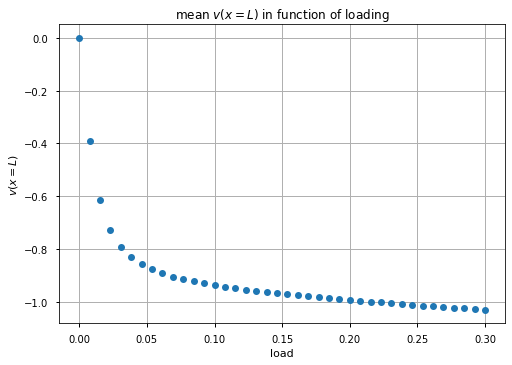

In [14]:
# Function building F(u, v)=0 with F = residual here
problem   = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver    = dolfin.NonlinearVariationalSolver(problem)

displ_ref = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0., 0.)))

file_u = dolfin.XDMFFile(os.path.join(output_dir, "u_ref.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})
for (i, t) in enumerate(loads):
    B.t = t       #add load to downwards gravity force
    solver.solve()
    
    displ_ref[i] = dolfin.assemble(u[1]*ds(boundary_indices["right"]))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)
        
plt.plot(loads, displ_ref, "o")

plt.title(r'mean $v(x=L)$ in function of loading')
plt.xlabel('load')
plt.ylabel(r'$v(x=L)$')

plt.grid(True)

## Implementation of the Newton–Raphson solver

We will discuss the statement below in class.

In [15]:
bcs_homo = bcs

In [16]:
def simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    
    """ Function displaying information on solution (residual, error, ...). """
    
    print("Iteration: {:3d}, Error: {:3.4e}, Residual: {:3.4e}".format(iteration, norm_delta_u, norm_residual))

# -----------

def plot_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    
    """ Function ploting u displacement. """
    
    simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual)
    
    plt.figure()
    dolfin.plot(u, mode="displacement") 

# -----------

def newton_solver(u, max_iter=100, rtol=1e-6, atol=1e-6, monitor=None):
    
    """ Newton Raphson solver returing converging u value 
    given u (initial guess ??) and nb iterations. """

    delta_u = dolfin.Function(V)
    delta_u.interpolate(dolfin.Constant((0., 0.)))

    bcs_homo = bcs

    for k in range(max_iter):

        # Solve the linearized problem for the increment delta_u with homogenous BCs
        problem_lin = dolfin.LinearVariationalProblem(jacobian, -residual, delta_u, bcs_homo)
        solver_lin  = dolfin.LinearVariationalSolver(problem_lin)
        solver_lin.solve() #value delta_u automatically updated
        
        # Update the solution
        u.assign(u+delta_u) #keeps u and du as 2 separate variables

        # ------------------
        # error calculation
        # ------------------

        # Stopping criterion based on the L2 norm of u and delta_u
        norm_delta_u = dolfin.norm(delta_u, "L2")
        norm_u       = dolfin.norm(      u, "L2")
            
        intR = dolfin.assemble(residual)
        bc.apply(intR)
        norm_residual = dolfin.norm(intR, "L2")
        
        # -----------------
        
        if monitor is not None:
            monitor(k, u, norm_u, norm_delta_u, norm_residual)
        
        else:
            # See for-else statement:
            # https://book.pythontips.com/en/latest/for_-_else.html#else-clause
            # This block is entered only if the above loop completes,
            # which means that the maximum number of iterations has been reached.
            1==1
#             print('You decided to display nothing')
#             raise RuntimeError("could not converge, norm_u {}, norm_delta_u {}".format(norm_u, norm_delta_u)) 

    return k

We are now ready to call our solver, first with a very small load, so that the solution is nearly that of the linear problem, and the algorithm should converge in one iteration.

In [17]:
bc = dolfin.DirichletBC(V, (0.,0.), left) #embedded condition to the left (x[0]==0)

# u = dolfin.Function(V)
u.interpolate(dolfin.Constant((0.0, 0.0)))
B.t = 1E-4

newton_solver(u, max_iter=3, monitor=simple_monitor)

Iteration:   0, Error: 9.3505e-04, Residual: 7.4519e-03
Iteration:   1, Error: 2.8341e-06, Residual: 1.9208e-07
Iteration:   2, Error: 8.5150e-11, Residual: 3.4640e-14


2

Let's try a slightly higher load. We will plot the estimate of the solution at each iteration. It is interesting to observe the iterates converge to the solution.

Iteration:   0, Error: 1.0519e-01, Residual: 6.5493e+01
Iteration:   1, Error: 3.8576e-02, Residual: 2.1611e+01


1

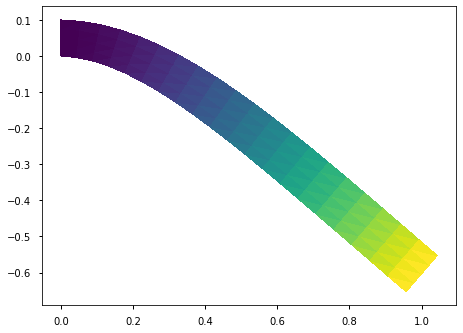

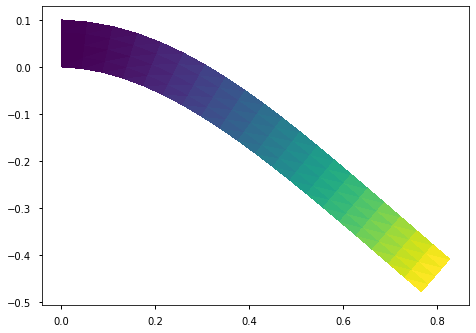

In [19]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = 1.5*load_max/n_loads

newton_solver(u, max_iter=2, monitor=plot_monitor)

### Illustrating quadratic convergence

We now want to verify that the Newton–Raphson iterations converge quadratically, that is $\epsilon_{n+1} \leq C\epsilon_n^2$, where $\epsilon_n$ denotes the error of the $n$-th iterate. Since we do not know the exact solution of the problem, we will take the last iterate as a reference.

We implement a new `monitor` that keeps a copy of each iterate.

In [16]:
iterates = []

def my_monitor(iteration, u, u_norm, delta_u_norm, residual_norm):
    simple_monitor(iteration, u, u_norm, delta_u_norm, residual_norm)
    iterates.append(u.copy(deepcopy=True))

u.interpolate(dolfin.Constant((0., 0.)))
B.t = 2.5*load_max/n_loads
newton_solver(u, monitor=my_monitor, rtol=1e-10, atol=1e-10)

Iteration:   0, Error: 1.7532e-01, Residual: 1.2599e+02
Iteration:   1, Error: 1.0718e-01, Residual: 1.2717e+02
Iteration:   2, Error: 2.1718e-02, Residual: 3.2448e+01
Iteration:   3, Error: 8.0147e-03, Residual: 8.6801e+00
Iteration:   4, Error: 1.0481e-02, Residual: 3.3536e+00
Iteration:   5, Error: 3.1996e-03, Residual: 7.4497e-01
Iteration:   6, Error: 4.1260e-03, Residual: 1.3838e-01
Iteration:   7, Error: 9.1179e-04, Residual: 1.0109e-02
Iteration:   8, Error: 2.4560e-04, Residual: 6.6514e-04
Iteration:   9, Error: 6.1657e-06, Residual: 5.7059e-07
Iteration:  10, Error: 1.1783e-08, Residual: 3.4327e-12
Iteration:  11, Error: 1.8830e-14, Residual: 2.5675e-12
Iteration:  12, Error: 1.1410e-16, Residual: 2.6331e-12
Iteration:  13, Error: 5.0522e-17, Residual: 2.5357e-12
Iteration:  14, Error: 4.1963e-17, Residual: 2.5138e-12
Iteration:  15, Error: 7.9575e-17, Residual: 2.6881e-12
Iteration:  16, Error: 7.7636e-17, Residual: 2.6858e-12
Iteration:  17, Error: 3.3466e-17, Residual: 2.8

99

**When approaching the solution, we should have** $r^{n+1} = r^{2n}$

In [17]:
L2_errors = np.zeros(len(iterates), dtype=np.float64)
H1_errors = np.zeros_like(L2_errors)
u_ref = iterates[-1]

for i, u_i in enumerate(iterates):
    L2_errors[i] = dolfin.errornorm(u_ref, u_i, 'L2')
    H1_errors[i] = dolfin.errornorm(u_ref, u_i, 'H1')

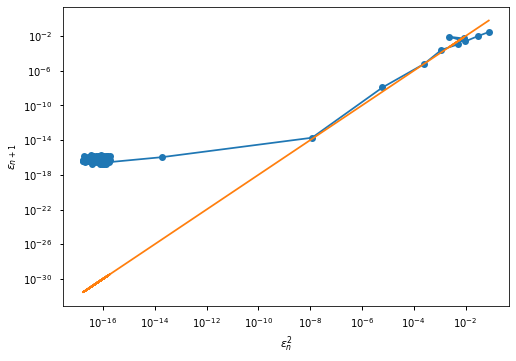

In [22]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(L2_errors[:-2], L2_errors[1:-1], 'o-')
plt.loglog(L2_errors[:-2], 100*L2_errors[:-2]**2)

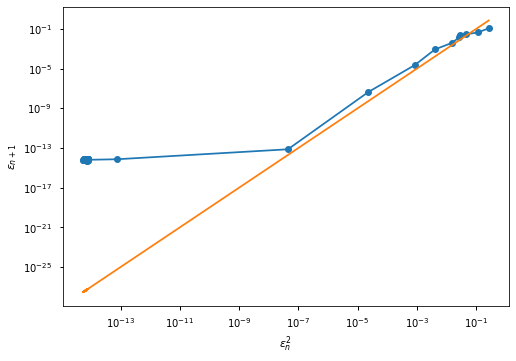

In [20]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(H1_errors[:-2], H1_errors[1:-1], 'o-')
plt.loglog(H1_errors[:-2], 10*H1_errors[:-2]**2)

## Validation of the solver

We now run the whole simulation and compare with the reference solution.

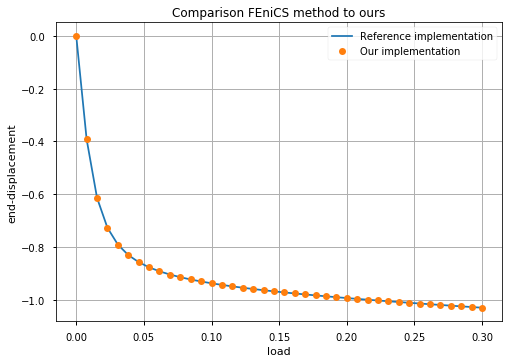

In [23]:
file_u = dolfin.XDMFFile(os.path.join(output_dir, "u.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})

# initialisation
displ = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0.,0.)))

B.t = 0

for (i, t) in enumerate(loads):
    B.t = t
    newton_solver(u, max_iter=10, monitor=None)
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)

plt.plot(loads, displ_ref, "-", label='Reference implementation')
plt.plot(loads, displ, 'o', label='Our implementation')

plt.title('Comparison FEniCS method to ours')
plt.ylabel("end-displacement")
plt.xlabel("load")

plt.grid(True)
plt.legend()

#### $L_2$ norm error

In [24]:
e_L2 = np.linalg.norm(displ - displ_ref, ord=2)
print(e_L2)

6.16713364149e-12


**We conclude on the fact our method is equivalent to FEniCS one, namely we manually implemented the same steps.**

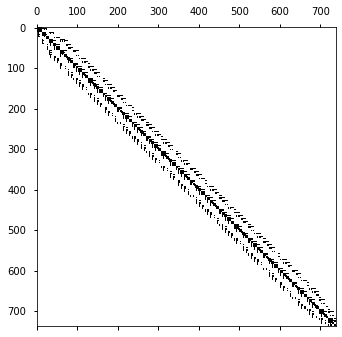

In [25]:
J_mat = dolfin.assemble(jacobian).array()
J_mat
plt.spy(J_mat)

# `Further questions`

### Question 0
Sometimes the Jacobian is too difficult to compute, try to replace it by a constant Jacobian (of the right dimension) and see if your obtain convergence.

In [26]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)] #embedded condition to the left (x[0]==0)
bc  =  dolfin.DirichletBC(V, (0.,0.), left) #embedded condition to the left (x[0]==0)

In [27]:
# WF
potential_energy = psi*dx - ufl.dot(B, u)*dx - ufl.dot(T, u)*ds(boundary_indices['right'])

residual = ufl.derivative(potential_energy, u, dolfin.TestFunction (V))
jacobian = ufl.derivative(residual        , u, dolfin.TrialFunction(V))

In [29]:
def newton_solver_identity_jacobian(u, max_iter=10, rtol=1e-6, atol=1e-6, monitor=None):
    
    """ Newton Raphson solver returing converging u value 
    given u (initial guess ??) and nb iterations. """

    delta_u = dolfin.Function(V)
    delta_u.interpolate(dolfin.Constant((0., 0.)))
    
    for k in range(max_iter):

        # Solve the linearized problem for the increment delta_u with homogenous BCs
        problem_lin = dolfin.LinearVariationalProblem(ufl.Identity(1), -residual, delta_u, bcs_homo)
        solver_lin  = dolfin.LinearVariationalSolver(problem_lin)
        solver_lin.solve() #value delta_u automatically updated
        
        # Update the solution
        u.assign(u+delta_u) #keeps u and du as 2 separate variables

        # ------------------
        # error calculation
        # ------------------

        # Stopping criterion based on the L2 norm of u and delta_u
        norm_delta_u = dolfin.norm(delta_u, "L2")
        norm_u       = dolfin.norm(      u, "L2")
            
        intR = dolfin.assemble(residual)
        bc.apply(intR)
        norm_residual = dolfin.norm(intR, "L2")
        
        # -----------------
        
        if monitor is not None:
            monitor(k, u, norm_u, norm_delta_u, norm_residual)
        
        else:
            # See for-else statement:
            # https://book.pythontips.com/en/latest/for_-_else.html#else-clause
            # This block is entered only if the above loop completes,
            # which means that the maximum number of iterations has been reached.
            1==1
#             print('You decided to display nothing')
#             raise RuntimeError("could not converge, norm_u {}, norm_delta_u {}".format(norm_u, norm_delta_u)) 

    return k

Wether the method converges depend on the shape of residual :
    
* considering residual af $f(x)$, we minimize it through several iterations.

* it comes $f(x) + f'(x)dx = 0$ and we look for dx.

* then we go step by step towards minimization (linearizing a non-linear problem)

Discussing the mater of the Jacobian matrix $f'(x)$, if we decide to fix it, it may be acceptable if :

* we approximate J by value close to $f'(x)$

* $f'(x)$ remains almost constant, i.e. $f'(x) \approx fixed ~~ Jacobian$

In [30]:
bc = dolfin.DirichletBC(V, (0.,0.), left) #embedded condition to the left (x[0]==0)

# u = dolfin.Function(V)
u.interpolate(dolfin.Constant((0.0, 0.0)))
B.t = 1E-4

newton_solver_identity_jacobian(u, max_iter=3, monitor=simple_monitor)

RuntimeError: Expected a ufl.Form.

**Question 1** Show that for large load steps, the iterations may cease to converge. Can you explain what is happening? 

In order to consider large load steps, one must do so through loading vector.

In [31]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)] #embedded condition to the left (x[0]==0)
bc  =  dolfin.DirichletBC(V, (0.,0.), left) #embedded condition to the left (x[0]==0)

In [32]:
def newton_solver_load_iter(u, max_iter=100, rtol=1e-6, atol=1e-6, monitor=None):
    
    """ Newton Raphson solver returing converging u value 
    given u (initial guess ??) and nb iterations. """

    delta_u = dolfin.Function(V)
    delta_u.interpolate(dolfin.Constant((0., 0.)))

    bcs_homo = bcs

    for k in range(max_iter):

        # Solve the linearized problem for the increment delta_u with homogenous BCs
        problem_lin = dolfin.LinearVariationalProblem(jacobian, -residual, delta_u, bcs_homo)
        solver_lin  = dolfin.LinearVariationalSolver(problem_lin)
        solver_lin.solve() #value delta_u automatically updated
        
        # Update the solution
        u.assign(u+delta_u) #keeps u and du as 2 separate variables

        # ------------------
        # error calculation
        # ------------------

        # Stopping criterion based on the L2 norm of u and delta_u
        norm_delta_u = dolfin.norm(delta_u, "L2")
        norm_u       = dolfin.norm(      u, "L2")
            
        intR = dolfin.assemble(residual)
        bc.apply(intR)
        norm_residual = dolfin.norm(intR, "L2")
        
        # -----------------
        
        if monitor is not None:
            monitor(k, u, norm_u, norm_delta_u, norm_residual)
        
        else:
            # See for-else statement:
            # https://book.pythontips.com/en/latest/for_-_else.html#else-clause
            # This block is entered only if the above loop completes,
            # which means that the maximum number of iterations has been reached.
            1==1
#             print('You decided to display nothing')
#             raise RuntimeError("could not converge, norm_u {}, norm_delta_u {}".format(norm_u, norm_delta_u)) 

    if m.isnan(norm_residual): #condition at the end as however if nan once, won't get any better (will it ?)
        return True
    
    return k

In [33]:
def min_nb_loads(nb_loads_iter):
    
    """ Function returing min nb loads given the 
    number of loading to test.
    
    It works as loads_iter = np.array([10*_ for _ in range(1, nb_loads_iter)])[::-1]
    
    such that provided 'nb_loads_iter', we test solving for a number of loading from 10 to 10*(nb_loads_iter-1)
    
    Note that we in fact test the highest nb loads until loop breaks of finishes.
    """
    
    nb_loads_iter = nb_loads_iter
    loads_iter = np.array([30 + _ for _ in range(1, nb_loads_iter)])[::-1]
    loads_iter = loads_iter.astype(int)

    # ---------
    
    # u = dolfin.Function(V)
    u.interpolate(dolfin.Constant((0.0, 0.0)))

    # ---------
    exit = False #initialisation condition to break loop if nan values encountered

    for i in range(nb_loads_iter-1):

        B.t = 0
        loads = np.linspace(load_min, load_max, loads_iter[i])

        for j in range(loads_iter[i]):
            B.t   = loads[j]

            # ------------

            norm_residual = newton_solver_load_iter(u, max_iter=10, monitor=None)

            if norm_residual==True:
                exit=True

        if exit==True:
            print('Doesn\'t converges for a load step above {:.4f}'.format((load_max - load_min)/loads_iter[i]))
            print('Equivalent to having {} steps.'.format(loads_iter[i]))    
            break
            
    return loads_iter[i]

In [34]:
# Display max space step together with min nb of loadings to consider (equivalent)
min_loads = min_nb_loads(5)
print('Min space step is ', load_max / min_loads)

Doesn't converges for a load step above 0.0094
Equivalent to having 32 steps.
Min space step is  0.009375


**Look at colormap graphic of displacement to have visual feedback showing too large load step may not ensure convergence.**

**It looks like the value for min space step may vary in function of max_load : ex. if one chooses max_load=0.4, one can converge with nb_load=39.**

**Non_linear FEniCS code may not work for loading array for which our solver works.**

**Question 2** Refine the mesh and observe how the largest load-step is affected.

In [1]:
# Physical mesh : rectangle 2D beam

def min_nb_loads_for_meshs_refinement(mesh_size_iter, nb_loads_iter):
    
    """ Function returning min_nb_loads for some mesh's refinement. """
    
    # ----------------
    
    Nx = np.array([10*_ for _ in range(1, mesh_size_iter)])
    stock_min_nb_loads = np.zeros_like((Nx))
    
    # ----------------

    for i in range(mesh_size_iter-1):

        # ---------------------------------------------
        #                 Mesh's refinement
        # ---------------------------------------------

        nx, ny = Nx[i], int(Nx[i]/5) # Number of elements in each direction

        # ------
        #  mesh
        # ------
        
        mesh  = dolfin.RectangleMesh(dolfin.Point(0,0),
                                     dolfin.Point(Lx,Ly),
                                     nx, ny)

        left  = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
        right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)

        boundary_markers = dolfin.MeshFunction("size_t", 
                                                mesh, 
                                                1, #dim
                                                0) #value

        boundary_indices = {"left": 1, "right": 2}
        left.mark (boundary_markers, boundary_indices["left"] )
        right.mark(boundary_markers, boundary_indices["right"])
        
        ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
        dx = dolfin.dx(domain=mesh)
        
        # ----------------
        #  Function space
        # ----------------
        
        V_element = dolfin.VectorElement("CG", #usual Lagrangian elements
                                 mesh.ufl_cell(), 
                                 degree=degree) #2

        V = dolfin.FunctionSpace(mesh, V_element)
        u = dolfin.Function(V, name="u") #name allows to work as with a pointer
        
        # ------------------
        #  Potential energy
        # ------------------
        
        I, F, C, Ic, J, E = tensors(u)

        #Hookean potential energy
        psi = (mu/2)*(Ic-2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
        
        bcs = [dolfin.DirichletBC(V, (0.,0.), left)] #embedded condition to the left (x[0]==0)
        bc  =  dolfin.DirichletBC(V, (0.,0.), left)  #embedded condition to the left (x[0]==0)
        
        # -------
        
        # WF
        potential_energy = psi*dx - ufl.dot(B, u)*dx - ufl.dot(T, u)*ds(boundary_indices['right'])

        residual = ufl.derivative(potential_energy, u, dolfin.TestFunction (V))
        jacobian = ufl.derivative(residual        , u, dolfin.TrialFunction(V))
        
        # ------------------------------------------------------------------------
        # ------------------------------------------------------------------------

        stock_min_nb_loads[i] = min_nb_loads(nb_loads_iter)
        
        plt.figure()
        dolfin.plot(mesh)
        
    return stock_min_nb_loads, Nx

In [2]:
min_loads, nx = min_nb_loads_for_meshs_refinement(mesh_size_iter=5, nb_loads_iter=5) # nb refinement=a-1 ; nb tested loads=b-1

NameError: name 'np' is not defined

In [ ]:
plt.plot(nx, min_loads, '.')

**Doesn't change for mesh refined. May it be we must ensure nx and ny independant.**

**Question 3** Replace the distributed loading with a prescribed vertical displacement at the tip of the cantilever.

**Question 4** For a distributed load equal "mu t (cos(alpha), sin(alpha))" with t = 0.01, plot the displacement as a function of alpha

**Question 5** Same question with t = 0.02